# **Time Series Regression Analysis**

The objective of this project is to create a time series regression model to predict the unit sales for thousands of items sold at different Favorita stores. The project will focus on regression models for this project. 

##### **Hypothesis:**

**H0: Promotions do not have a significant impact on store sales.**

**H1: Promotions have a significant positive impact on store sales.**

**Data Analytics questions**

1. Which dates have the lowest and highest sales for each year (excluding days the store was closed)?
2. Compare the sales for each month across the years and determine which month of which year had the highest sales.
3. Did the earthquake impact sales?
4. Are certain stores or groups of stores selling more products? (Cluster, city, state, type)
5. Are sales affected by promotions, oil prices and holidays?
6. Which product family and stores did the promotions affect.
7. Does the payment of wages in the public sector on the 15th and last days of the month influence the store sales.

## **Business Understanding and Data preparation**


### **Data loading**

This is step includes importing the relevant libraries and loading data from different sources. 

In [105]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import pyodbc 
import seaborn as sns 
import sqlalchemy as sa
from sqlalchemy import create_engine
from dotenv import dotenv_values
from dotenv import load_dotenv
from scipy.stats import ttest_ind
import warnings

warnings.filterwarnings('ignore')

Load the data from various sources:

1. Database, three tables(dbo.oil, dbo.holidays_events,dbo.store) 
2. Onedrive .csv
3. Github .csv 

In [51]:
# Load environment variables from .env file into a dictionary
environment_variables = dotenv_values('.env')
# Get the values for the credentials you set in the '.env' file
database = environment_variables.get("DATABASE")
server = environment_variables.get("SERVER")
username = environment_variables.get("USERNAME")
password = environment_variables.get("PASSWORD")
connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}"


In [52]:
connection_string=f"DRIVER={{SQL Server}};SERVER={"dap-projects-database.database.windows.net"};DATABASE={"dapDB"};UID={"learning_project_3"};PWD={"A$uB1Lp3$2@24"}"
connection = pyodbc.connect(connection_string)

In [53]:
# Write SQL Query to get data from the database.
query="Select * from dbo.oil"
oil = pd.read_sql(query,connection)

# Display the first 5 rows of the data

oil.head(6)


,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997
5,2013-01-08,93.209999


In [54]:
query="Select * from dbo.holidays_events"
holidays_events = pd.read_sql(query,connection)

# Display the first 5 rows of the data

holidays_events.head(6)

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
5,2012-05-12,Holiday,Local,Puyo,Cantonizacion del Puyo,False


In [55]:
holidays_events['locale_name'].unique()

array(['Manta', 'Cotopaxi', 'Cuenca', 'Libertad', 'Riobamba', 'Puyo',
       'Guaranda', 'Imbabura', 'Latacunga', 'Machala', 'Santo Domingo',
       'El Carmen', 'Cayambe', 'Esmeraldas', 'Ecuador', 'Ambato',
       'Ibarra', 'Quevedo', 'Santo Domingo de los Tsachilas',
       'Santa Elena', 'Quito', 'Loja', 'Salinas', 'Guayaquil'],
      dtype=object)

In [56]:
query="Select * from dbo.stores"
stores = pd.read_sql(query,connection)

# Display the first 5 rows of the data

stores.head(6)

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4
5,6,Quito,Pichincha,D,13


Load the transaction.csv file 

In [57]:
train=pd.read_csv(r"C:\Users\user\OneDrive\Time-series-regression\Data\train.csv")

train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


### **Assess the datasets**
1. Get a summary of the datasets using info()
2. Assess the missing values using isnull()

In [58]:
"""create a list of the datasets and  another list for the names of the datasets. This will help us check the info and null values in one block of code"""
dataframes=[oil, holidays_events, stores, train]
names=["oil", "holidays", "stores", "train"]

#run a for loop to iterate over the dataframes checking the information
for df,name in zip(dataframes, names):
    print(f"info for {name}:")
    print(df.info())
    print("\n")


info for oil:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB
None


info for holidays:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB
None


info for stores:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Coun

In [59]:


for df, name in zip(dataframes,names):
    print(f"missing values in {name}:")
    print(df.isnull().sum())
    print("\n")

missing values in oil:
date           0
dcoilwtico    43
dtype: int64


missing values in holidays:
date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64


missing values in stores:
store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64


missing values in train:
id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64




All the columns in each dataframe are the correct datatype and the only dataframe with a missing value is the oil dataset in which the dcoilwtico column is missing 43 values 

In [60]:
#rename the dcoilwtico column to oil_price 
oil.rename(columns={'dcoilwtico': 'oil_price'},inplace=True)

#rename the type column to store_type
stores.rename(columns={'type':'store_type'},inplace=True)

#rename the type column to day_type in holidays_events dataframe to make it consistent with the other datasets.
holidays_events.rename(columns={'type':'day_type'}, inplace=True)


In [61]:
holidays_events

,date,day_type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


In [62]:
oil['oil_price'].fillna(oil['oil_price'].mean(),inplace=True)

Merge the datasets using an inner join. 

In [63]:
#merge the train and oil datasets on the date column using an inner join
train=pd.merge(train,oil[['date','oil_price']],on='date',how='inner')

#merge train_1 and holiday_events on the date column with and inner join picking only the type, local and transferred columns form holiday events. 
train=pd.merge(train,holidays_events[['date','day_type','locale','locale_name','transferred']], on='date',how="inner")

#merge train_1 and store datasets on store number on the store_nbr columns picking only the city, store_type and cluster columns 
train=pd.merge(train,stores[['store_nbr','city','store_type','cluster']], on='store_nbr',how='inner')

train.head(10)

,id,date,store_nbr,family,sales,onpromotion,oil_price,day_type,locale,locale_name,transferred,city,store_type,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,67.714366,Holiday,National,Ecuador,False,Quito,D,13
1,1,2013-01-01,1,BABY CARE,0.0,0,67.714366,Holiday,National,Ecuador,False,Quito,D,13
2,2,2013-01-01,1,BEAUTY,0.0,0,67.714366,Holiday,National,Ecuador,False,Quito,D,13
3,3,2013-01-01,1,BEVERAGES,0.0,0,67.714366,Holiday,National,Ecuador,False,Quito,D,13
4,4,2013-01-01,1,BOOKS,0.0,0,67.714366,Holiday,National,Ecuador,False,Quito,D,13
5,5,2013-01-01,1,BREAD/BAKERY,0.0,0,67.714366,Holiday,National,Ecuador,False,Quito,D,13
6,6,2013-01-01,1,CELEBRATION,0.0,0,67.714366,Holiday,National,Ecuador,False,Quito,D,13
7,7,2013-01-01,1,CLEANING,0.0,0,67.714366,Holiday,National,Ecuador,False,Quito,D,13
8,8,2013-01-01,1,DAIRY,0.0,0,67.714366,Holiday,National,Ecuador,False,Quito,D,13
9,9,2013-01-01,1,DELI,0.0,0,67.714366,Holiday,National,Ecuador,False,Quito,D,13


In [64]:
train.isnull().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
oil_price      0
day_type       0
locale         0
locale_name    0
transferred    0
city           0
store_type     0
cluster        0
dtype: int64

In [65]:
train.duplicated()

0         False
1         False
2         False
3         False
4         False
          ...  
352831    False
352832    False
352833    False
352834    False
352835    False
Length: 352836, dtype: bool

### **Exploratory data analysis**

This will involve univariate analysis, bivariate analysis and multivariate analysis 

**Univariate Analysis**

In [66]:
train.describe()

,id,store_nbr,sales,onpromotion,oil_price,cluster
count,3.528360e+05,352836.000000,352836.000000,352836.000000,352836.000000,352836.000000
mean,1.628316e+06,27.500000,370.968396,3.402351,65.570880,8.481481
std,7.954575e+05,15.585806,1196.785036,14.857531,24.380015,4.649741
min,0.000000e+00,1.000000,0.000000,0.000000,27.959999,1.000000
25%,9.751990e+05,14.000000,0.000000,0.000000,45.320000,4.000000
50%,1.687554e+06,27.500000,12.000000,0.000000,54.020000,8.500000
75%,2.183840e+06,41.000000,202.000000,0.000000,94.250000,13.000000
max,3.000887e+06,54.000000,124717.000000,716.000000,107.949997,17.000000


 The columns sales and onpromotion show particularly high variability compared to their means, suggesting significant differences in sales amounts and the number of promotions across entries. The id, store_nbr, oil_price, and cluster columns show moderate variability relative to their means.

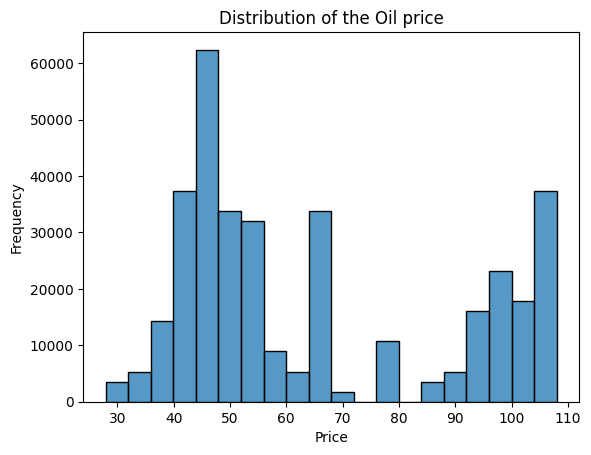

In [67]:
sns.histplot(train, x='oil_price', bins=20)
plt.title("Distribution of the Oil price")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

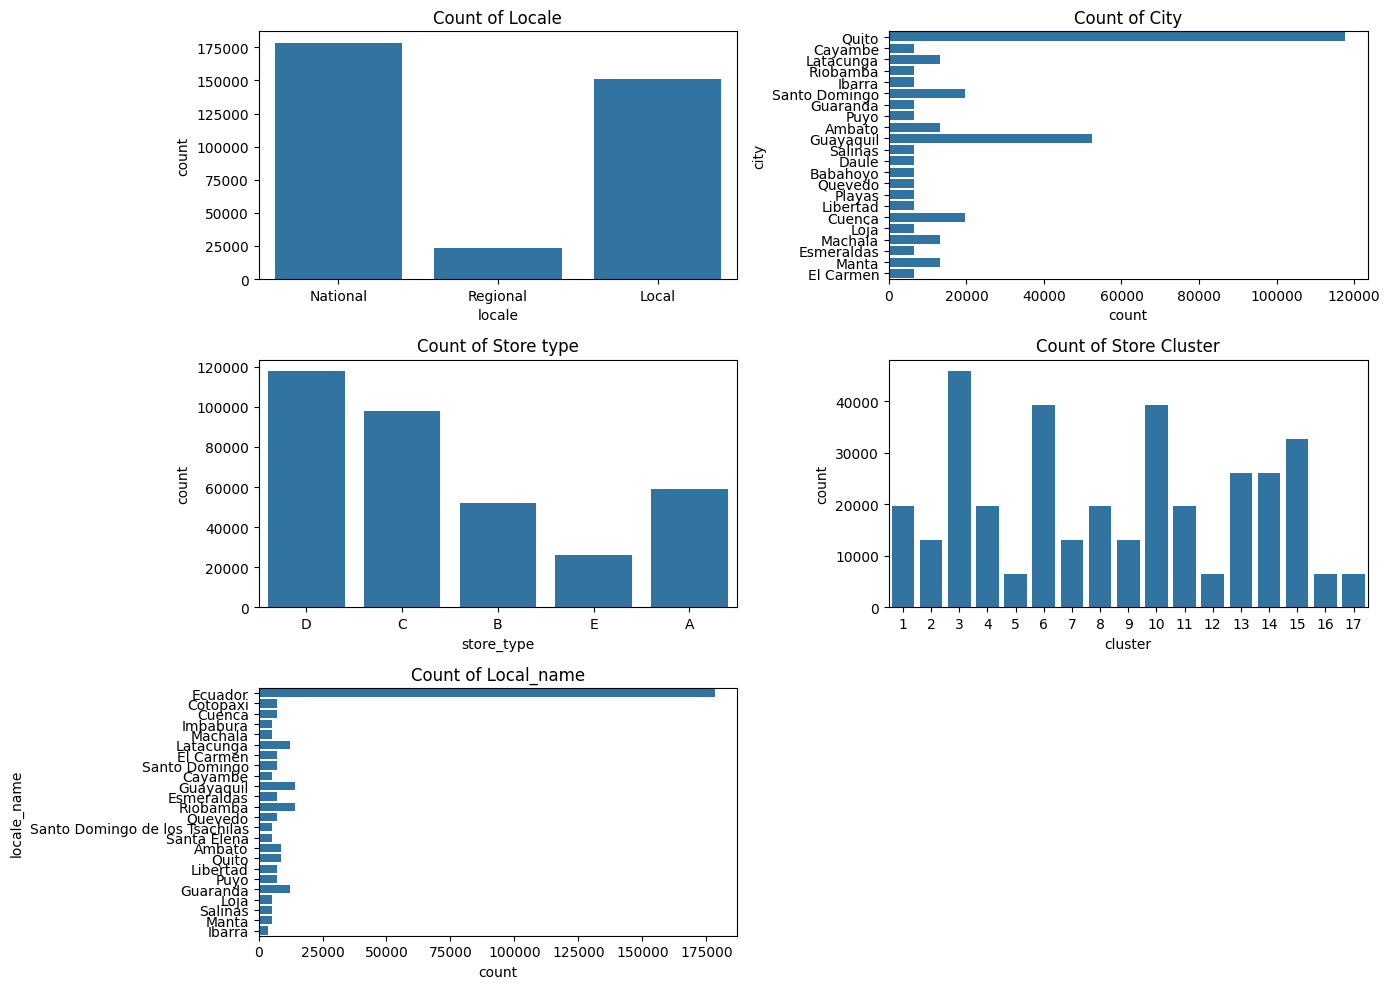

In [68]:
#create a figurre with subplots 
fig,axes=plt.subplots(3,2,figsize=(14,10))

#flatten the axes array for easy iteration
axes=axes.flatten()


#Plot countplot for each column


sns.countplot(x='locale',data=train,ax=axes[0])
axes[0].set_title("Count of Locale")
plt.xticks(rotation=45)

sns.countplot(y='city',data=train,ax=axes[1])
axes[1].set_title("Count of City")
plt.xticks(rotation=45)

sns.countplot(x="store_type",data=train, ax=axes[2])
axes[2].set_title("Count of Store type")
plt.xticks(rotation=45)

sns.countplot(x="cluster",data=train,ax=axes[3])
axes[3].set_title("Count of Store Cluster")
plt.xticks(rotation=45)

sns.countplot(y='locale_name', data=train, ax=axes[4])
axes[4].set_title("Count of Local_name")


# Remove the last empty subplot
fig.delaxes(axes[5])

#Adjust layout
plt.tight_layout()

#Show plot
plt.show()




**Bivariate Analysis**

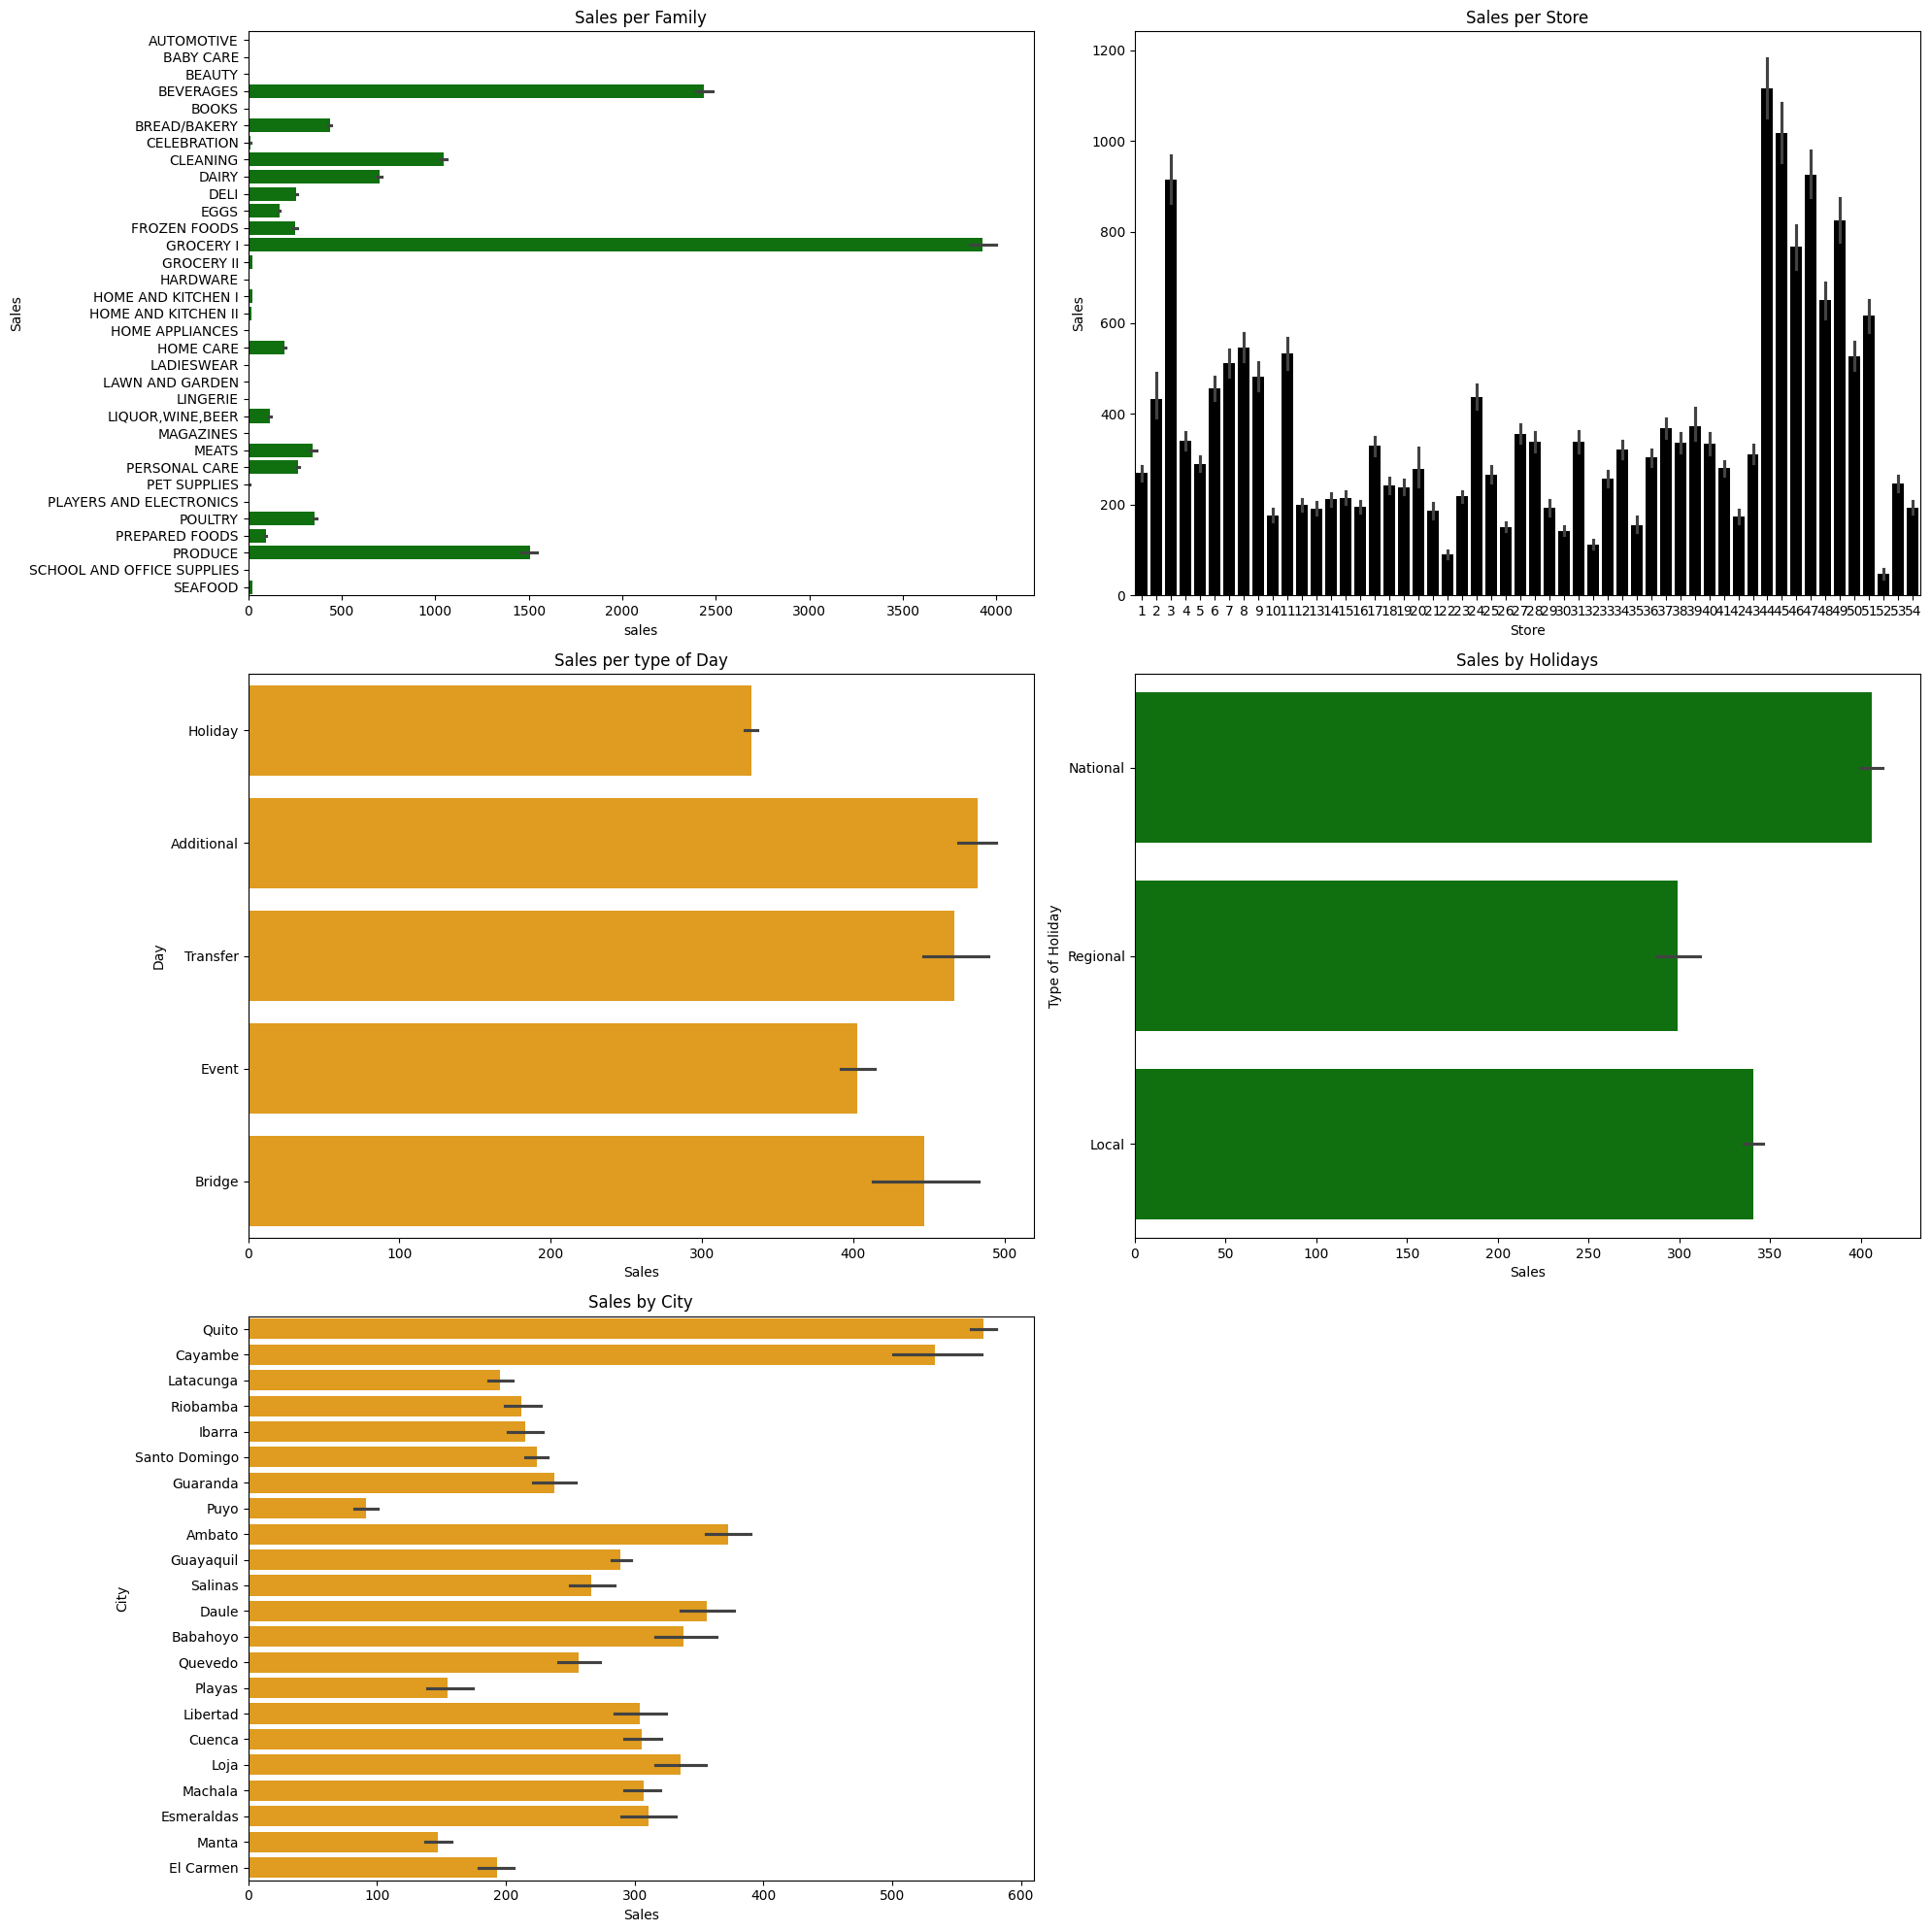

In [69]:
# create bivariate graphs


fig,axes=plt.subplots(3,2, figsize=(20,20))

#flatten the axes array for easy iteration
axes=axes.flatten()


#plot each bar graph 

sns.barplot(y=train['family'],x=train['sales'],color='green',ax=axes[0])
axes[0].set_ylabel("Family")
axes[0].set_ylabel("Sales")
axes[0].set_title("Sales per Family")

sns.barplot(x="store_nbr", y="sales",data=train ,color="Black", ax=axes[1])
axes[1].set_xlabel("Store")
axes[1].set_ylabel("Sales")
axes[1].set_title("Sales per Store")

sns.barplot(x="sales",y="day_type", data=train, color="orange",ax=axes[2])
axes[2].set_xlabel("Sales")
axes[2].set_ylabel("Day")
axes[2].set_title("Sales per type of Day")

sns.barplot(x="sales",y="locale",data=train, color="green",ax=axes[3])
axes[3].set_title("Sales by Holidays")
axes[3].set_xlabel("Sales")
axes[3].set_ylabel("Type of Holiday")

sns.barplot(x="sales", y="city", data=train, color="orange",ax=axes[4])
axes[4].set_title("Sales by City")
axes[4].set_ylabel("City")
axes[4].set_xlabel("Sales")

#delete 6th plot 
fig.delaxes(axes[5])

#adjust layout
plt.tight_layout()

#show plot
plt.show()

In [70]:
#Convert date to datetime format 
train["date"]=pd.to_datetime(train["date"])



In [71]:
sales=train.groupby('date').agg({"sales":'sum'})

sales.head()

,sales
date,
2013-01-01,2511.618999
2013-02-11,278627.588926
2013-02-12,308800.790912
2013-04-01,428816.447912
2013-04-12,314394.967035


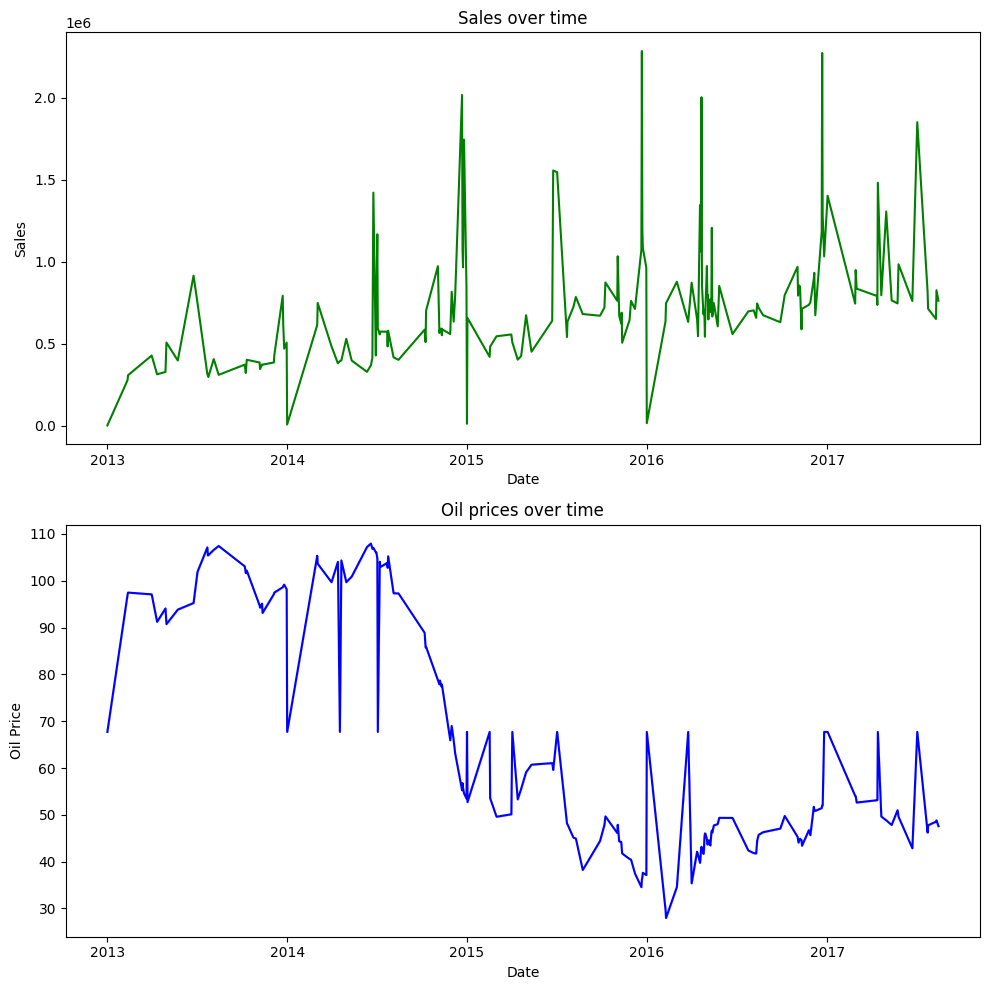

In [72]:
fig,axes=plt.subplots(2,1,figsize=(10,10))

#flatten axes
axes=axes.flatten()

#plot sales over time and oil prices over time 

sns.lineplot(data=sales, x="date",y="sales", color= "green", ax=axes[0])
axes[0].set_title("Sales over time")
axes[0].set_ylabel("Sales")
axes[0].set_xlabel("Date")

sns.lineplot(data=train, x="date",y="oil_price", color= "blue", ax=axes[1])
axes[1].set_title("Oil prices over time")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Oil Price")

#Adjust the layout
plt.tight_layout()

#show plot
plt.show()

**Multivariate Analysis**

In [73]:
top10=train.nlargest(10,'sales')

top10

,id,date,store_nbr,family,sales,onpromotion,oil_price,day_type,locale,locale_name,transferred,city,store_type,cluster
246291,2163723,2016-05-02,2,GROCERY I,124717.000,59,44.750000,Event,National,Ecuador,False,Quito,D,13
286200,2445984,2016-10-07,39,MEATS,89576.360,0,49.759998,Holiday,Local,Quevedo,False,Cuenca,B,6
232476,2144154,2016-04-21,20,GROCERY I,87438.516,53,43.180000,Holiday,Local,Riobamba,False,Quito,B,6
232477,2144154,2016-04-21,20,GROCERY I,87438.516,53,43.180000,Event,National,Ecuador,False,Quito,B,6
227613,2139699,2016-04-18,45,GROCERY I,76090.000,38,39.740002,Event,National,Ecuador,False,Quito,A,11
239163,2153031,2016-04-26,2,GROCERY I,63434.000,30,42.520000,Event,National,Ecuador,False,Quito,D,13
234258,2145045,2016-04-21,45,GROCERY I,53874.000,44,43.180000,Holiday,Local,Riobamba,False,Quito,A,11
234259,2145045,2016-04-21,45,GROCERY I,53874.000,44,43.180000,Event,National,Ecuador,False,Quito,A,11
44034,562596,2013-11-12,44,GROCERY I,46271.000,0,93.120003,Holiday,Local,Ambato,False,Quito,A,5
127458,1257246,2014-12-08,35,GROCERY I,45361.000,3,63.130001,Holiday,Local,Loja,False,Playas,C,3


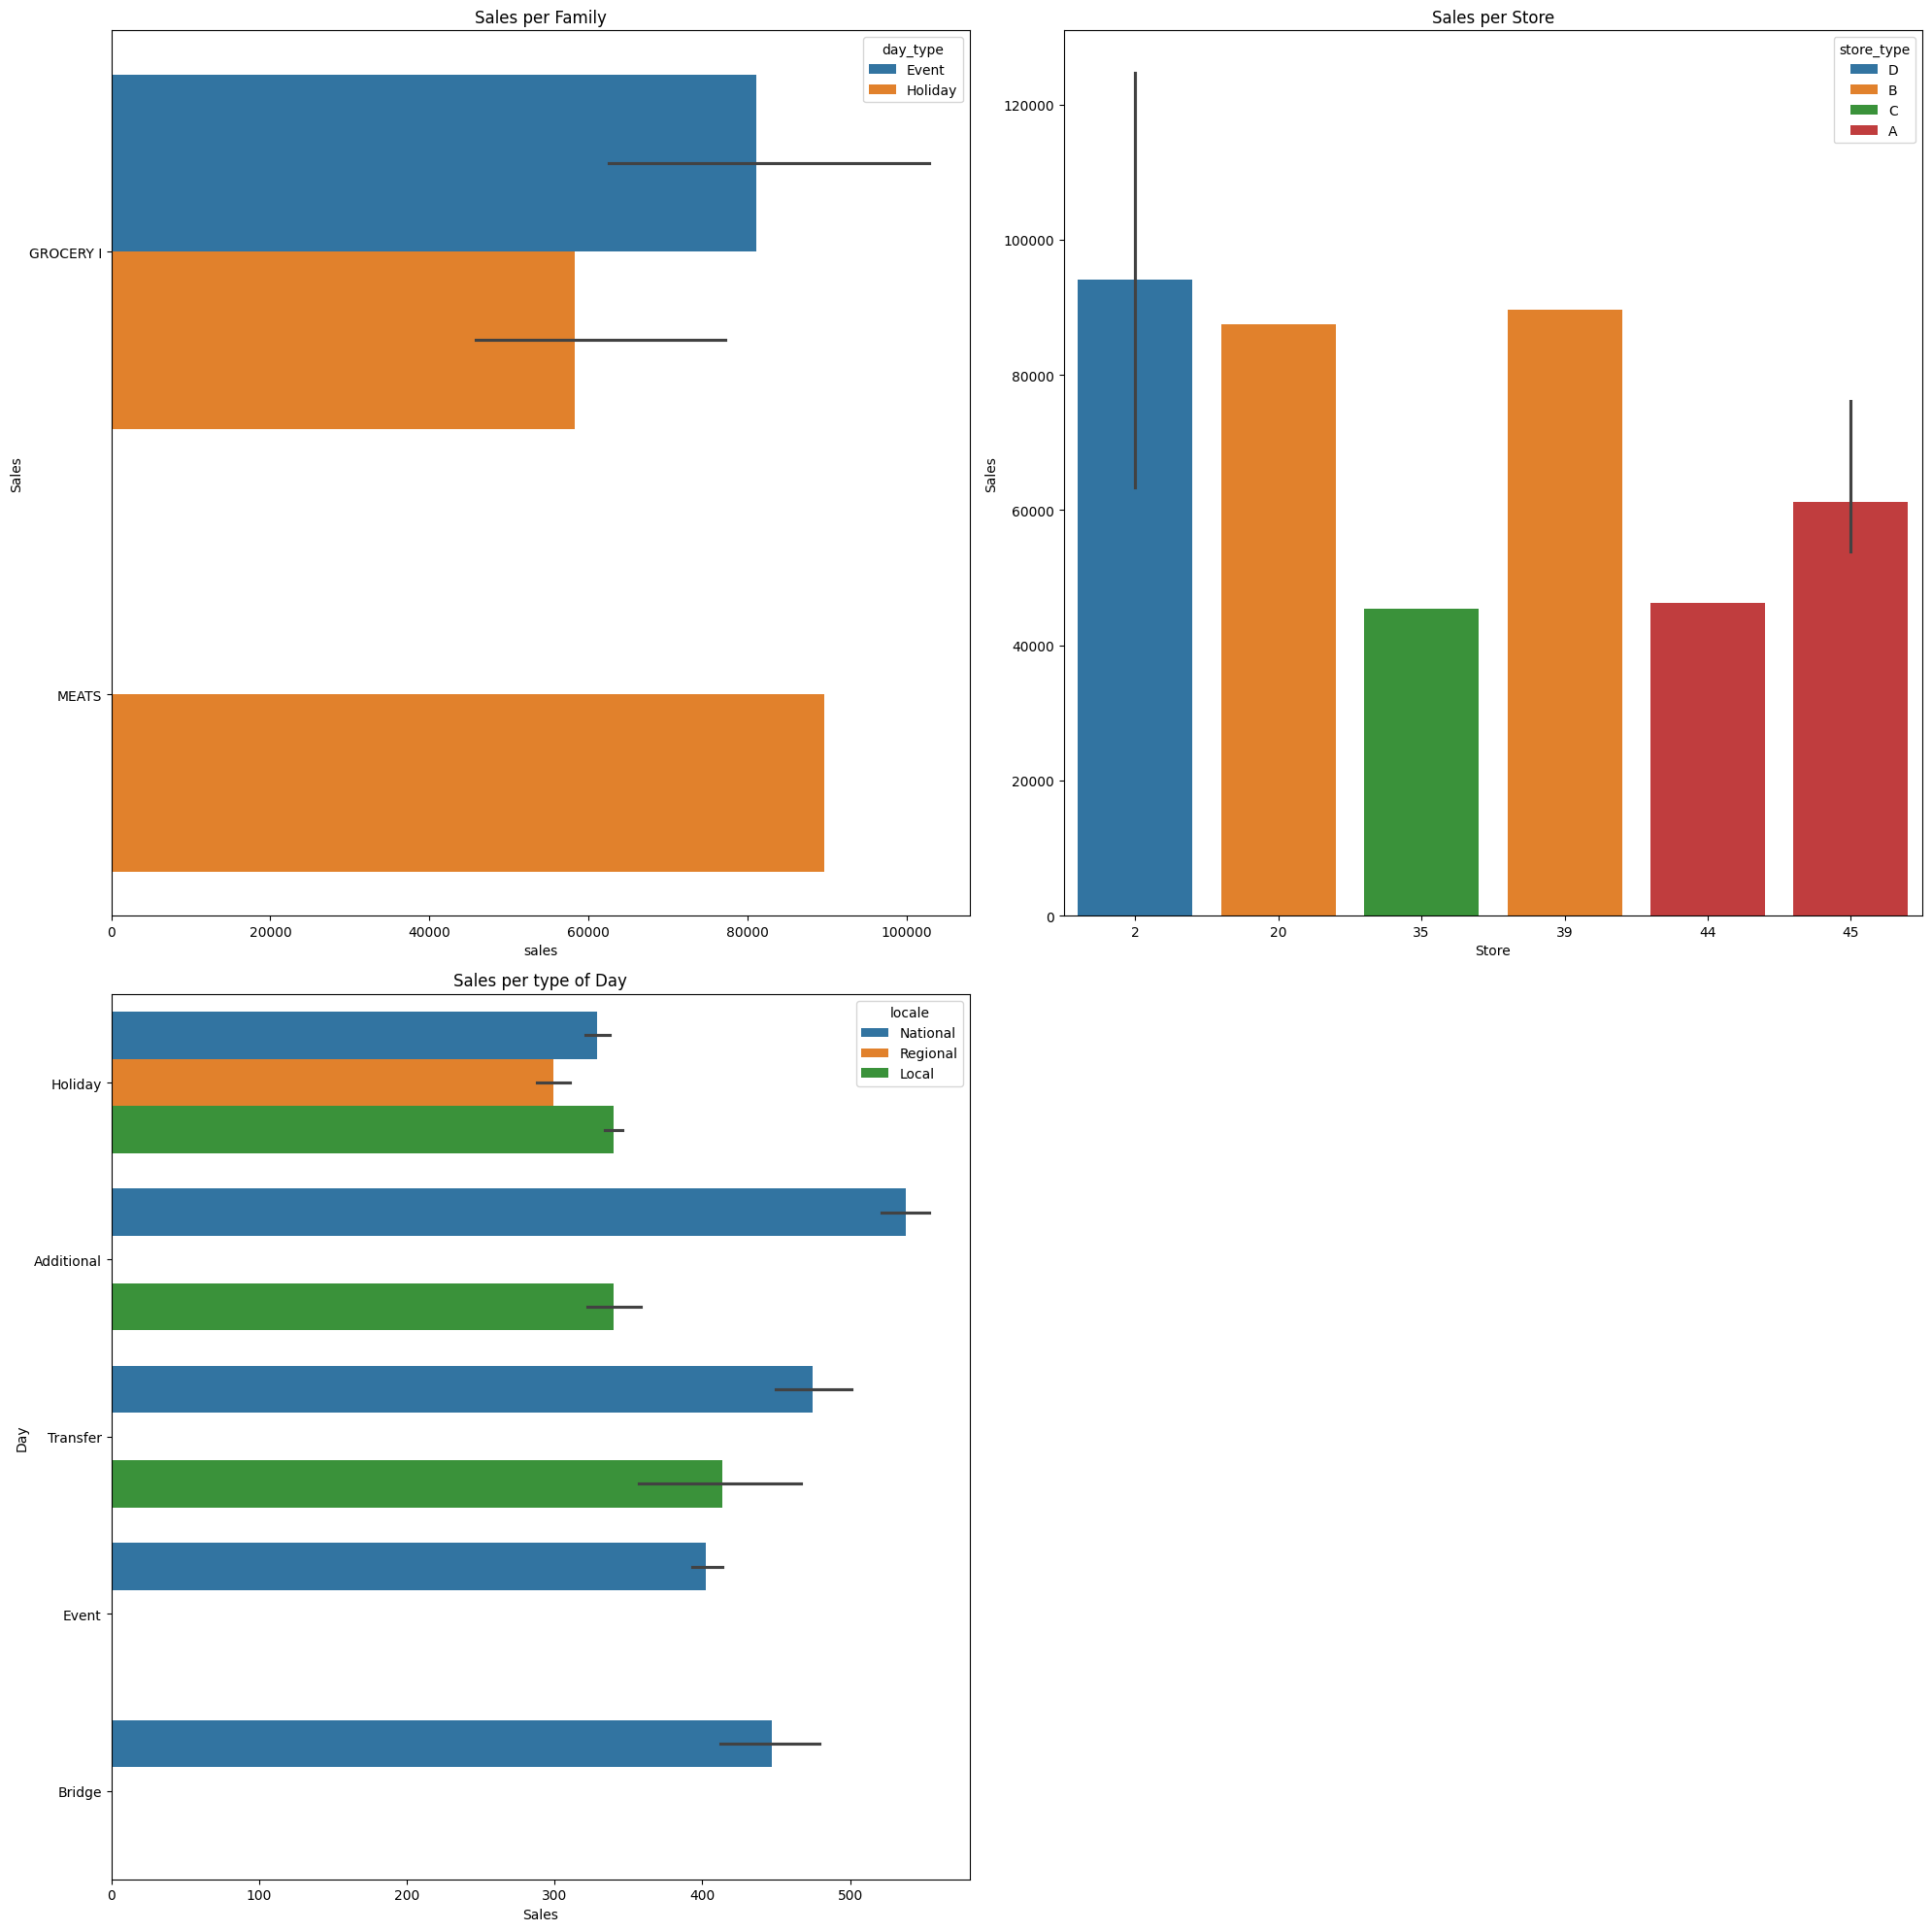

In [74]:
# create bivariate graphs


fig,axes=plt.subplots(2,2, figsize=(20,20))

#flatten the axes array for easy iteration
axes=axes.flatten()


#plot each bar graph 

sns.barplot(y='family',x='sales',hue="day_type", data=top10 ,ax=axes[0])
axes[0].set_ylabel("Family")
axes[0].set_ylabel("Sales")
axes[0].set_title("Sales per Family")

sns.barplot(x="store_nbr", y="sales",data=top10, hue='store_type',ax=axes[1])
axes[1].set_xlabel("Store")
axes[1].set_ylabel("Sales")
axes[1].set_title("Sales per Store")

sns.barplot(x="sales",y="day_type", data=train, hue='locale',ax=axes[2])
axes[2].set_xlabel("Sales")
axes[2].set_ylabel("Day")
axes[2].set_title("Sales per type of Day")



#delete 6th plot 
fig.delaxes(axes[3])

#adjust layout
plt.tight_layout()

#show plot
plt.show()

##### **Data Analytics Questions**

1. Which dates have the lowest and highest sales for each year (excluding days the store was closed)?


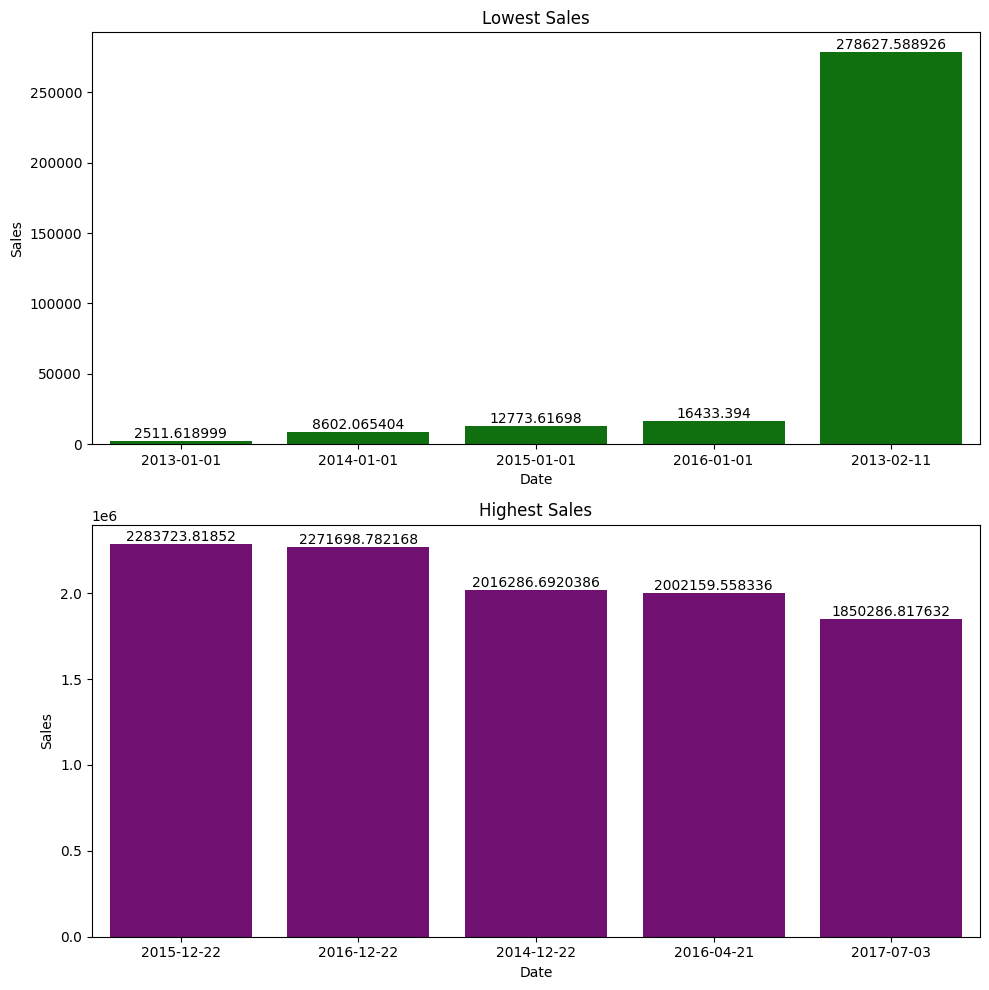

In [75]:
#Aggregate sales per day using the group by function
Daily_sales=train.groupby('date').agg({'sales':'sum'})

#Filter out the lowest 5 sales 
lowest_sales=Daily_sales.nsmallest(5,'sales')

#Filter out the highest 5 sales
highest_sales=Daily_sales.nlargest(5,'sales')

#Plot the results 

fig, axes=plt.subplots(2,1,figsize=(10,10))

#flatten axes
axes=axes.flatten()

#Plot the top 5 and bottom 5 sales 

sns.barplot(data=lowest_sales, x="date",y="sales", color= "green", ax=axes[0])
axes[0].set_title("Lowest Sales")
axes[0].set_ylabel("Sales")
axes[0].set_xlabel("Date")

#Annotate the plot
for i in range(len(lowest_sales)):
    axes[0].annotate(f'{lowest_sales["sales"][i]}',
                     xy=(i, lowest_sales["sales"][i]),
                     ha='center',va="bottom")

sns.barplot(data=highest_sales, x='date',y='sales',color='purple',ax=axes[1])
axes[1].set_title("Highest Sales")
axes[1].set_ylabel("Sales")
axes[1].set_xlabel("Date")

#Annotate the plot
for i in range(len(highest_sales)):
    axes[1].annotate(f'{highest_sales["sales"][i]}',
                     xy=(i, highest_sales["sales"][i]),
                     ha='center',va='bottom')

plt.tight_layout()
plt.show()

2. Compare the sales for each month across the years and determine which month of which year had the highest sales.


In [96]:

new_train=train
new_train["month"]=new_train['date'].dt.month_name()
new_train["year"]=new_train['date'].dt.year

#Group by month and year and calculate the sum of sales

monthly_sales=new_train.groupby(['year','month']).agg({'sales':'sum'}).reset_index()
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']


sales_2013=monthly_sales[monthly_sales['year']==2016]
sales_2013['month'] = pd.Categorical(sales_2013['month'], categories=month_order, ordered=True)

sales_2014=monthly_sales[monthly_sales['year']==2014]
sales_2014['month'] = pd.Categorical(sales_2014['month'], categories=month_order, ordered=True)

sales_2015=monthly_sales[monthly_sales['year']==2015]
sales_2015['month'] = pd.Categorical(sales_2015['month'], categories=month_order, ordered=True)

sales_2016=monthly_sales[monthly_sales['year']==2016]
sales_2016['month'] = pd.Categorical(sales_2016['month'], categories=month_order, ordered=True)

sales_2017=monthly_sales[monthly_sales['year']==2017]
sales_2017['month'] = pd.Categorical(sales_2017['month'], categories=month_order, ordered=True)


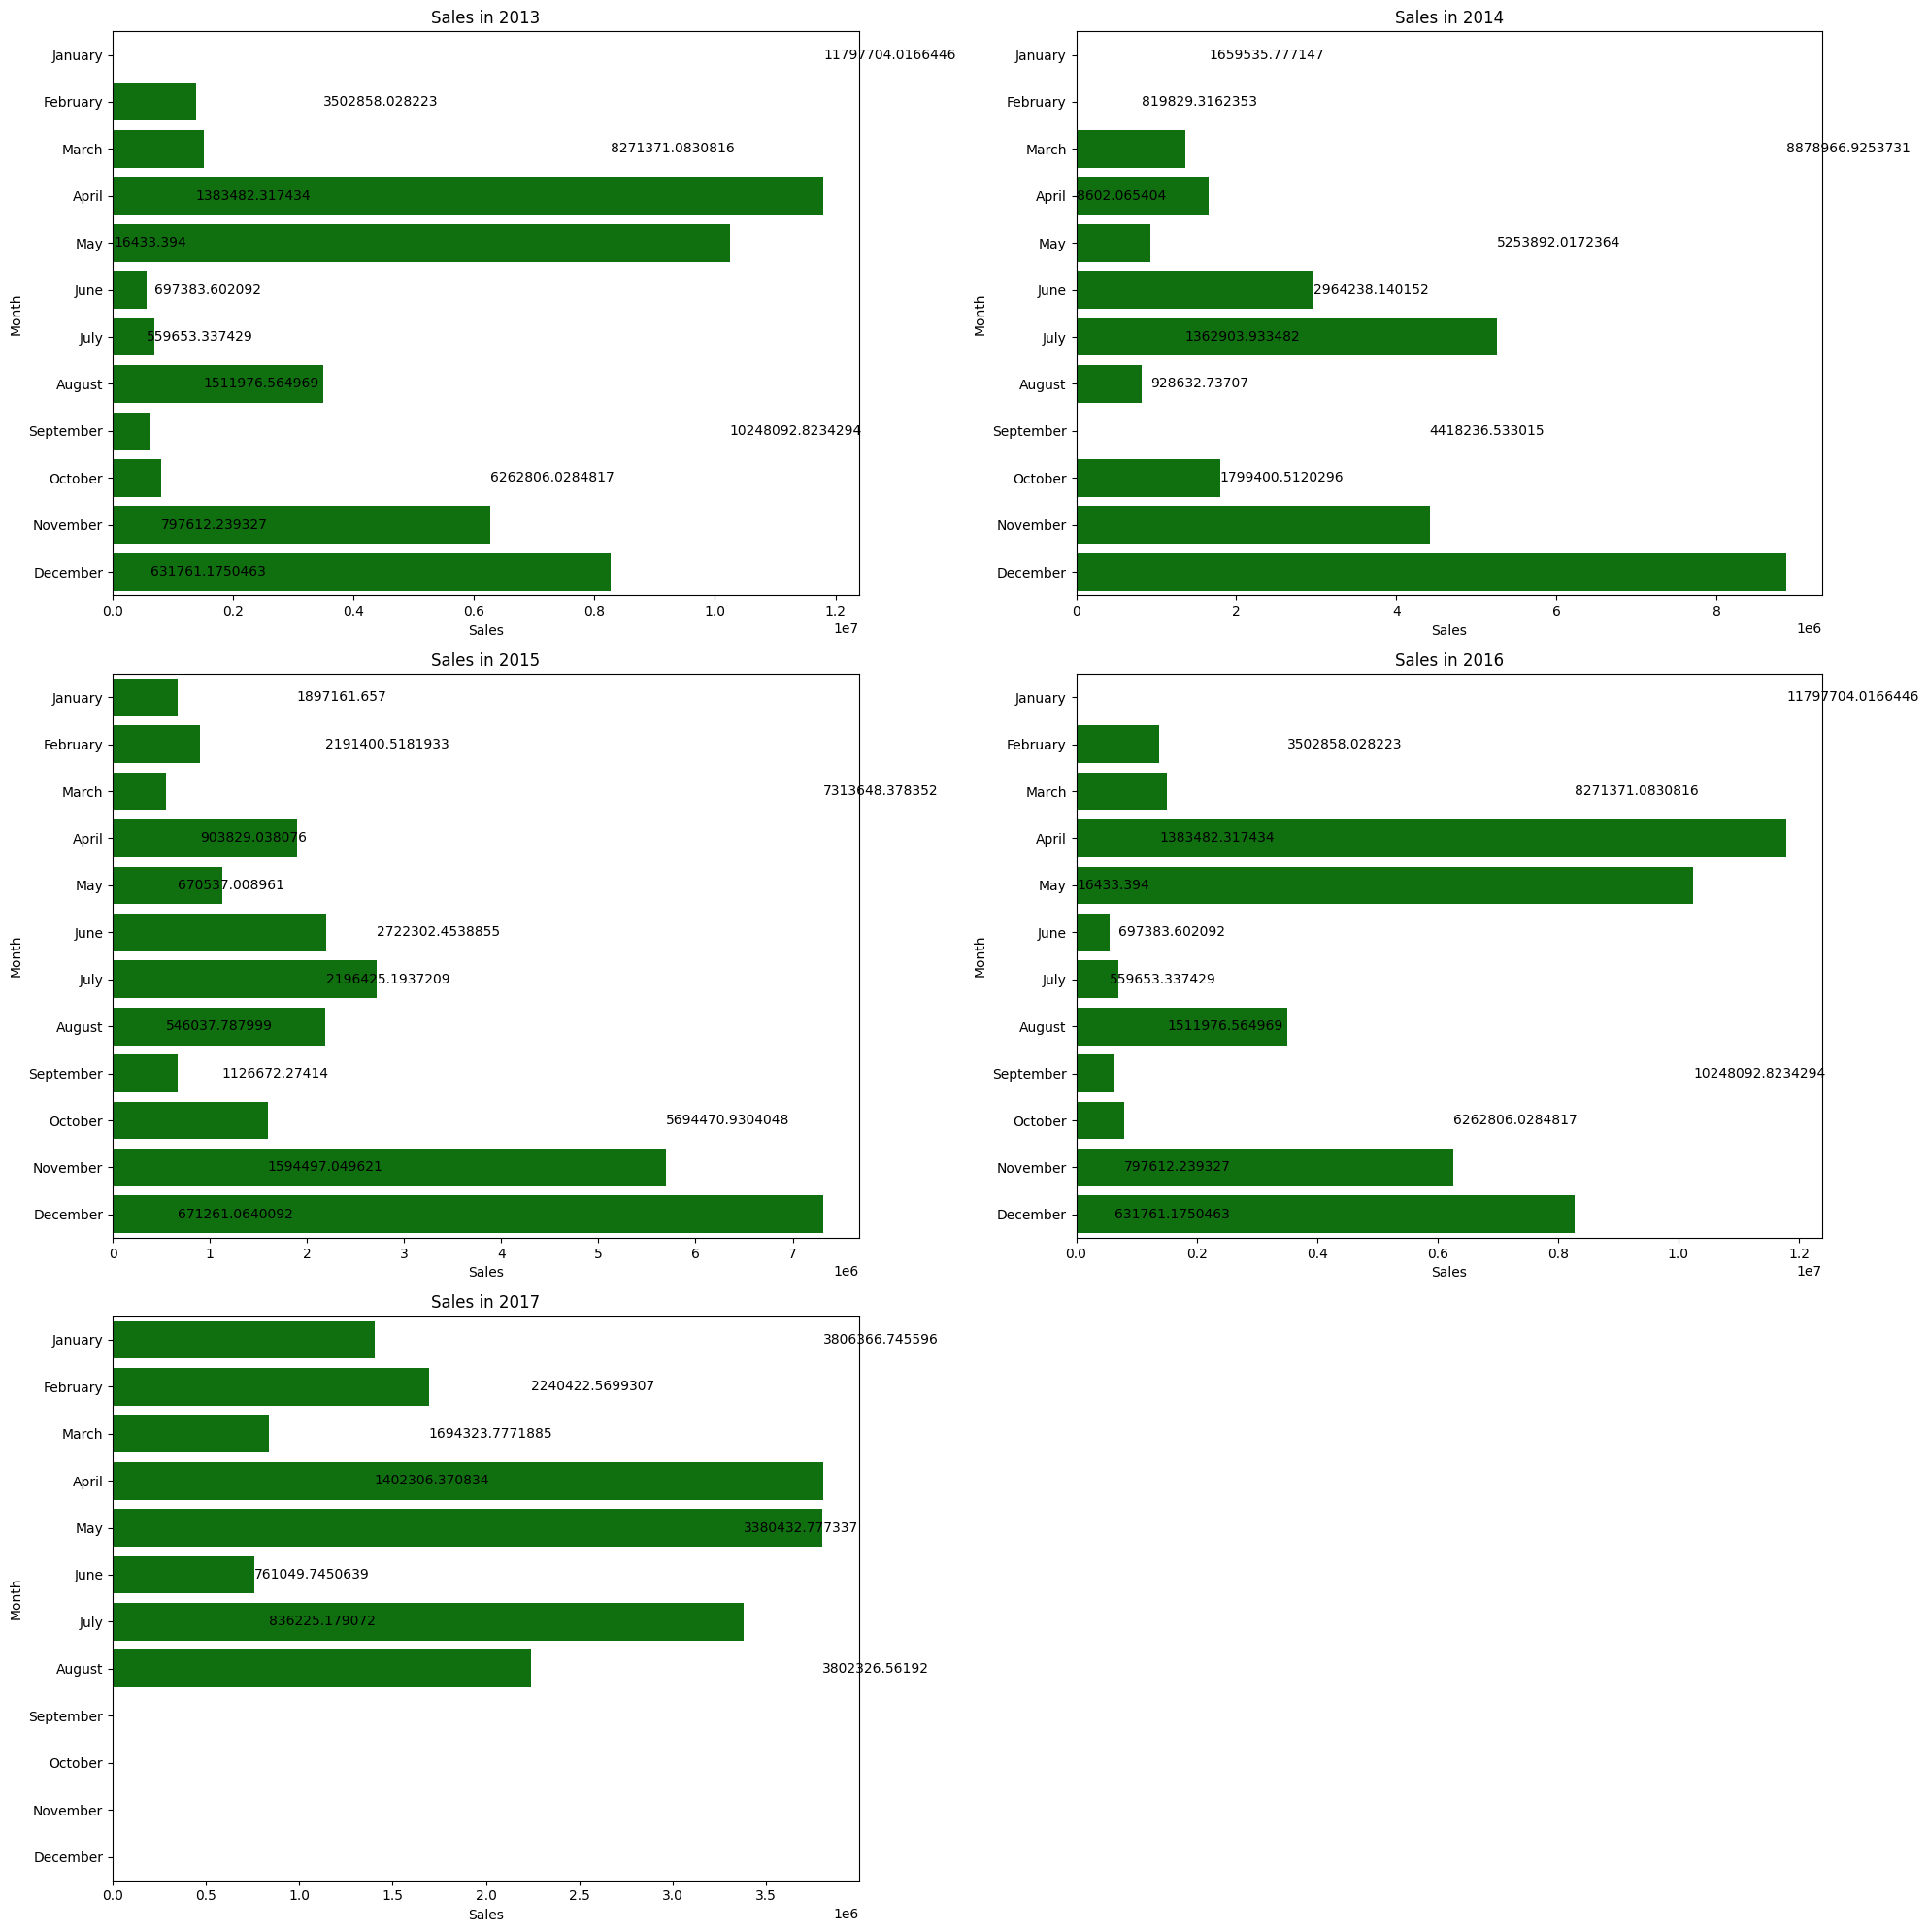

In [103]:
#Plot the results 

fig, axes=plt.subplots(3,2,figsize=(20,20))

#flatten axes
axes=axes.flatten()

#Plot the top 5 and bottom 5 sales 

sns.barplot(data=sales_2013, y="month",x="sales", color= "green", ax=axes[0])
axes[0].set_title("Sales in 2013")
axes[0].set_xlabel("Sales")
axes[0].set_ylabel("Month")

#Annotate the plot
for i in range(len(sales_2013)):
    axes[0].annotate(f'{sales_2013["sales"].iloc[i]}',
                     xy=( sales_2013["sales"].iloc[i], i),
                     va='center',ha="left")

sns.barplot(data=sales_2014,  y="month",x="sales", color= "green", ax=axes[1])
axes[1].set_title("Sales in 2014")
axes[1].set_xlabel("Sales")
axes[1].set_ylabel("Month")

#Annotate the plot
for i in range(len(sales_2014)):
    axes[1].annotate(f'{sales_2014["sales"].iloc[i]}',
                     xy=( sales_2014["sales"].iloc[i], i),
                     va='center',ha="left")

sns.barplot(data=sales_2015,  y="month",x="sales", color= "green", ax=axes[2])
axes[2].set_title("Sales in 2015")
axes[2].set_xlabel("Sales")
axes[2].set_ylabel("Month")

#Annotate the plot
for i in range(len(sales_2015)):
    axes[2].annotate(f'{sales_2015["sales"].iloc[i]}',
                     xy=( sales_2015["sales"].iloc[i], i),
                     ha='left',va="center")
    
sns.barplot(data=sales_2016,  y="month",x="sales", color= "green", ax=axes[3])
axes[3].set_title("Sales in 2016")
axes[3].set_xlabel("Sales")
axes[3].set_ylabel("Month")

#Annotate the plot
for i in range(len(sales_2016)):
    axes[3].annotate(f'{sales_2016["sales"].iloc[i]}',
                     xy=( sales_2016["sales"].iloc[i], i),
                     ha='left',va="center")

sns.barplot(data=sales_2017,  y="month",x="sales", color= "green", ax=axes[4])
axes[4].set_title("Sales in 2017")
axes[4].set_xlabel("Sales")
axes[4].set_ylabel("Month")

#Annotate the plot
for i in range(len(sales_2017)):
    axes[4].annotate(f'{sales_2017["sales"].iloc[i]}',
                     xy=( sales_2017["sales"].iloc[i], i),
                     ha='left',va="center")
    
#delete empty axis 
fig.delaxes(axes[5])

plt.tight_layout()
plt.show()

3. Did the earthquake impact sales?


In [106]:
#set the earthquake day 
earthquake_date=pd.to_datetime('16-04-2016')

#split the dataframe into before the earthquake and after the earthquake 

pre_earthquake=train[train['date']<earthquake_date]
post_earthquake=train[train['date']>earthquake_date]

#perform a t-test to compare sales before and after the earthquake 

t_stat, p_value=ttest_ind(pre_earthquake['sales'], post_earthquake['sales'])

print(f'T-statistic: {t_stat}, P-value: {p_value}')

T-statistic: -34.33410162205526, P-value: 6.507905672287107e-258


The p value is less than 0.05 indicating that there was a difference in sales before and after the earthquake.

4. Are certain stores or groups of stores selling more products? (Cluster, city, state, type)


In [107]:
fig, axes=plt.subplots(2,1,figsize=(10,10))

#flatten axes
axes=axes.flatten()

#plot the bar plots 

sns.barplot(data=train, x="cluster", y="sales", color="blue", ax=axes[0])
axes[0].set_title("Sales by Store")
axes[0].set_xlabel("Cluster")
axes[0].set_ylabel("Sales")

sns.barplot(data=train, x="city", y="sales", color="blue", ax=axes[1])
axes[1].set_title("Sales by City")      
axes[1].set_xlabel("City")
axes[1].set_ylabel("Sales")

sns.barplot(data=train, x='store_type',y='sales', color='green',ax=axes[2])
axes[2].set_ylabel("

SyntaxError: unterminated string literal (detected at line 19) (2171294119.py, line 19)

5. Are sales affected by promotions, oil prices and holidays?


6. Which product family and stores did the promotions affect.


7. Does the payment of wages in the public sector on the 15th and last days of the month influence the store sales.